In [102]:
#config

import os
base_dir='.'

train_im=os.path.join(base_dir,r"/content/drive/MyDrive/Colab Notebooks/data/icdar_train_im")
train_txt=os.path.join(base_dir,r"/content/drive/MyDrive/Colab Notebooks/data/icdar_train_txt")

test_im=os.path.join(base_dir,r"/content/drive/MyDrive/Colab Notebooks/data/icdar_test_im")
test_txt=os.path.join(base_dir,r"/content/drive/MyDrive/Colab Notebooks/data/icdar_test_txt")

IOU_NEGATIVE=0.3
IOU_POSITIVE=0.7

height, width=(512, 512)

tar_pos=128
total_anch=256

checkpoints_dir = r"/content/drive/MyDrive/Colab Notebooks/data/checkpoints"



Utils

In [103]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

In [104]:
#gen_anchor function genrates the shape of the anchors which in turn define how the model looks for text
# in the given image

def gen_anchor(featuresize, scale):

    heights=[11, 16, 23, 33, 47, 67, 96, 137, 196, 280]
    widths=[16, 16, 16, 16, 16, 16, 16, 16, 16, 16]

    # gen k=9 anchor size (h,w)
    heights=np.array(heights).reshape(len(heights), 1)
    widths=np.array(widths).reshape(len(widths), 1)

    base_anchor=np.array([0, 0, 15, 15])
    # center x,y
    xt=(base_anchor[0]+base_anchor[2]) * 0.5
    yt=(base_anchor[1]+base_anchor[3]) * 0.5

    # x1 y1 x2 y2
    x1=xt-widths * 0.5
    y1=yt-heights * 0.5
    x2=xt+widths * 0.5
    y2=yt+heights * 0.5
    base_anchor=np.hstack((x1, y1, x2, y2)) #column-wise/horizontal stacking of multi-dim arrays
    #print(base_anchor)
    h, w=featuresize
    shift_x=np.arange(0, w) * scale # returns consecutive integers from 0-w multiplied by scale
    shift_y=np.arange(0, h) * scale # returns consecutive integers from 0-h multiplied by scale
    # apply shift
    anchor=[]
    for i in shift_y:
        for j in shift_x:
            anchor.append(base_anchor+[j, i, j, i]) # adds the list to the existing base anchor
    return np.array(anchor).reshape((-1, 4))

a=gen_anchor((10,10),1)

In [105]:
#calculates the ratio of intersection over union for two polygons(rectangles)

def cal_iou(box1, box1_area, boxes2, boxes2_area):

    x1=np.maximum(box1[0], boxes2[:, 0])
    x2=np.minimum(box1[2], boxes2[:, 2])
    y1=np.maximum(box1[1], boxes2[:, 1])
    y2=np.minimum(box1[3], boxes2[:, 3])

    intersection=np.maximum(x2-x1, 0)*np.maximum(y2-y1, 0)
    iou=intersection/(box1_area+boxes2_area[:]-intersection[:])
    return iou

In [106]:
def cal_overlaps(boxes1, boxes2):

    area1=(boxes1[:, 0]-boxes1[:, 2])*(boxes1[:, 1]-boxes1[:, 3])
    area2=(boxes2[:, 0]-boxes2[:, 2])*(boxes2[:, 1]-boxes2[:, 3])

    overlaps=np.zeros((boxes1.shape[0], boxes2.shape[0]))

    # calculate the intersection of  boxes1(anchor) and boxes2(GT box)
    for i in range(boxes1.shape[0]):
        overlaps[i][:]=cal_iou(boxes1[i], area1[i], boxes2, area2)

    return overlaps

In [107]:
def bbox_transfrom(anchors, gtboxes):

    Cy=(gtboxes[:, 1]+gtboxes[:, 3])*0.5
    Cya=(anchors[:, 1]+anchors[:, 3])*0.5
    Cx=(gtboxes[:, 0]+gtboxes[:, 2])*0.5
    Cxa=(anchors[:, 0]+anchors[:, 2])*0.5

    h=gtboxes[:, 3]-gtboxes[:, 1]+1.0
    ha=anchors[:, 3]-anchors[:, 1]+1.0
    wa=anchors[:, 2]-anchors[:, 0]+1.0

    Vc=(Cy-Cya)/ha
    Vh=np.log(h/ha)
    Vx=(Cx-Cxa)/wa

    return np.vstack((Vc, Vh)).transpose(), Vx

In [108]:
#calculate region-proposal-network
def cal_rpn(imgsize, featuresize, scale, gtboxes):

    imgh, imgw=imgsize

    # gen base anchor
    base_anchor=gen_anchor(featuresize, scale)

    # calculate iou
    overlaps=cal_overlaps(base_anchor, gtboxes)

    # init labels -1 don't care  0 is negative  1 is positive
    labels=np.empty(base_anchor.shape[0])
    labels.fill(-1)

    # for each GT box corresponds to an anchor which has highest IOU
    gt_argmax_overlaps=overlaps.argmax(axis=0)

    # the anchor with the highest IOU overlap with a GT box
    anchor_argmax_overlaps=overlaps.argmax(axis=1)
    anchor_max_overlaps=overlaps[range(overlaps.shape[0]), anchor_argmax_overlaps]

    # IOU > IOU_POSITIVE
    labels[anchor_max_overlaps > IOU_POSITIVE]=1
    # IOU <IOU_NEGATIVE
    labels[anchor_max_overlaps < IOU_NEGATIVE]=0
    # ensure that every GT box has at least one positive RPN region
    labels[gt_argmax_overlaps]=1

    # only keep anchors inside the image
    outside_anchor = np.where(
        (base_anchor[:, 0] < 0) |
        (base_anchor[:, 1] < 0) |
        (base_anchor[:, 2]>=imgw) |
        (base_anchor[:, 3]>=imgh)
    )[0]
    labels[outside_anchor]=-1

    num_pos=len(np.where(labels==1)[0])
    if num_pos>tar_pos:
        for i in np.random.choice(np.where(labels==1)[0], num_pos-tar_pos, replace=False):
            labels[i]=-1

    num_neg=len(np.where(labels==0)[0])
    if num_neg>total_anch-tar_pos:
        for i in np.random.choice(np.where(labels==0)[0], num_neg-total_anch+tar_pos, replace=False):
            labels[i]=-1

    bbox_targets, refinements=bbox_transfrom(base_anchor, gtboxes[anchor_argmax_overlaps, :])

    return [labels, bbox_targets, refinements], base_anchor

Data preparation

In [109]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [110]:
class Data(Dataset):

    def __init__(self, datadir, labelsdir, test=False):

        self.datadir=datadir
        self.img_names=os.listdir(self.datadir)
        self.labelsdir=labelsdir
        self.test=test

    def __len__(self):
        return len(self.img_names)


    def box_transfer_v2(self,coor_lists,rescale_h,rescale_w):

        gtboxes = []

        for coor_list in coor_lists:
            coors_x=[int(coor_list[2*i]) for i in range(int(len(coor_list)/2))]
            coors_y=[int(coor_list[2*i+1]) for i in range(int(len(coor_list)/2))]

            xmin=int(min(coors_x)/rescale_w)
            xmax=int(max(coors_x)/rescale_w)
            ymin=int(min(coors_y)/rescale_h)
            ymax=int(max(coors_y)/rescale_h)

            prev=xmin

            for i in range(xmin//16+1, xmax//16+1):
                nxt=16*i-0.5
                gtboxes.append((prev, ymin, nxt, ymax))
                prev=nxt
            gtboxes.append((prev, ymin, xmax, ymax))

        return np.array(gtboxes)

    def parse_gtfile(self,gt_path,rescale_h,rescale_w):

        coor_lists=list()

        with open(gt_path,encoding="utf-8") as f:

            content=f.readlines()

            for line in content:

                if self.test==False:
                    coor_list=line.split(',')[:8]
                else:
                    coor_list=line.split(' ')[:4]

                coor_lists.append(coor_list)

        return self.box_transfer_v2(coor_lists,rescale_h,rescale_w)

    def draw_boxes(self,img,cls,base_anchors,gt_box):

        for i in range(gt_box.shape[0]):

            pt1=(int(gt_box[i][0]),int(gt_box[i][1]))
            pt2=(int(gt_box[i][2]),int(gt_box[i][3]))
            img=cv2.rectangle(img, pt1, pt2, (100, 200, 100),3)

        return img

    def __getitem__(self, idx):

        # reading the image according to idx

        img_name=self.img_names[idx]
        img_path=os.path.join(self.datadir, img_name)
        img=cv2.imread(img_path)

        # if the image does not exist then use a default image i.e. image_1
        # store all the unread images in a separate txt file
        if img is None:
            with open(r'/content/drive/MyDrive/Colab Notebooks/data/error_imgs.txt','a',encoding='utf-8') as f:
                f.write('{}\n'.format(img_path))

            img_name='img_1.png'
            img_path=os.path.join(self.datadir, img_name)
            img=cv2.imread(img_path)

        # generating the bounding boxes and classification probability of each box in each image
        h, w, c=img.shape

        rescale_h=float(h)/height
        rescale_w=float(w)/width

        h=int(float(h)/rescale_h)
        w=int(float(w)/rescale_w)
        img=cv2.resize(img,(w,h))

        # parsing the txt file associated with each image
        gt_path=os.path.join(self.labelsdir, r'gt_'+img_name.split('.')[0]+'.txt')
        gtbox=self.parse_gtfile(gt_path,rescale_h,rescale_w)

        [cls, regr, refine], base_anchors=cal_rpn((h, w), (int(h / 16), int(w / 16)), 16, gtbox)
        debug_img=self.draw_boxes(img.copy(),cls,base_anchors,gtbox)


        debug_img=cv2.resize(debug_img,(height,width))

        regr=np.hstack([cls.reshape(cls.shape[0], 1), regr])
        refine=np.hstack([cls.reshape(cls.shape[0], 1), refine.reshape(refine.shape[0], 1)])

        cls=np.expand_dims(cls, axis=0)

        # transforming to torch tensor for feeding into the model

        img=torch.from_numpy(img.transpose([2, 0, 1])).float()
        cls=torch.from_numpy(cls).float()
        regr=torch.from_numpy(regr).float()
        refine=torch.from_numpy(refine).float()

        return debug_img, img, cls, regr, refine

In [118]:
batch_size=1
dataset=Data(train_im,train_txt)
lo=DataLoader(dataset,shuffle=True,num_workers=0,batch_size=batch_size)

Model

In [119]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import os

In [120]:
class regr_loss(nn.Module):

    def __init__(self, device):
        super(regr_loss, self).__init__()

        self.device=device

    def forward(self, inp, target):

        cls=target[0, :, 0]
        regr=target[0, :, 1:]
        regr_keep=(cls == 1).nonzero(as_tuple=False)[:, 0]
        regr_true=regr[regr_keep]
        regr_pred=inp[0][regr_keep]
        diff=torch.abs(regr_true-regr_pred)

        less_one=(diff<1.0).float()

        loss = less_one*0.5*(diff**2) + torch.abs(1-less_one)*(diff-0.5)

        loss = torch.sum(loss, 1)
        loss = torch.mean(loss) if loss.numel()>0 else torch.tensor(0.0)

        return loss.to(self.device)

In [121]:
class cls_loss(nn.Module):

    def __init__(self,device):
        super(cls_loss, self).__init__()

        self.device = device

    def forward(self, inp, target):

        y_true = target[0][0]
        cls_keep = (y_true != -1).nonzero(as_tuple=False)[:, 0]
        cls_true = y_true[cls_keep].long()
        cls_pred = inp[0][cls_keep]

        loss = F.nll_loss(F.log_softmax(cls_pred, dim=-1), cls_true)  # negative-log-likelihood loss
        loss = torch.mean(loss) if loss.numel() > 0 else torch.tensor(0.0)

        return loss.to(self.device)

In [122]:
class conv_block(nn.Module):

    def __init__(self, inp, out, kernel, stride=1, padding=0, activation=True, bn=False, bias=True):
        super().__init__()

        self.conv=nn.Conv2d(inp, out, kernel, stride=stride, padding=padding, bias=bias)
        self.norm=nn.BatchNorm2d(out, eps=1e-5, momentum=0.01, affine=True)
        self.relu=nn.ReLU(inplace=True)

        self.rel=activation
        self.bn=bn

    def forward(self, x):

        x = self.conv(x)

        if self.bn==True:
            x=self.norm(x)

        if self.rel==True:
            x=self.relu(x)

        return x

In [123]:
class CTPN(nn.Module):

    def __init__(self):
        super().__init__()

        base_model=models.vgg16(pretrained=True)
        layers=list(base_model.features)[:-1]
        self.base_layers=nn.Sequential(*layers)  # block5_conv3 output

        self.conv1=conv_block(512, 512, 3, 1, 1) #region-proposal network layer
        self.recurrent=nn.LSTM(512,128, bidirectional=True, batch_first=True)
        self.conv2=conv_block(256, 512, 1, 1)

        self.cls=conv_block(512, 10*2, 1, 1, activation=False)
        self.regr=conv_block(512, 10*2, 1, 1)
        self.refine=conv_block(512, 10, 1, 1)

    def forward(self, x):

        x=self.base_layers(x)

        # rpn
        x=self.conv1(x)

        x1=x.permute(0,2,3,1).contiguous()
        b=x1.size()
        x1=x1.view(b[0]*b[1], b[2], b[3])

        x2,_=self.recurrent(x1)

        xsz=x.size()
        x3=x2.view(xsz[0], xsz[2], xsz[3], 256)

        x3=x3.permute(0,3,1,2).contiguous()
        x3=self.conv2(x3)
        x=x3

        cls=self.cls(x)
        regr=self.regr(x)
        refine=self.refine(x)

        cls=cls.permute(0,2,3,1).contiguous()
        regr=regr.permute(0,2,3,1).contiguous()
        refine=refine.permute(0,2,3,1).contiguous()

        cls=cls.view(cls.size(0), cls.size(1)*cls.size(2)*10, 2)
        regr=regr.view(regr.size(0), regr.size(1)*regr.size(2)*10, 2)
        refine=refine.view(refine.size(0), refine.size(1)*refine.size(2)*10, 1)

        return cls, regr, refine

Training

In [124]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
import torch.optim as optim
import os
import numpy as np
import datetime as dt


device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

cuda


In [125]:
def save_checkpoint(model_dict, extension = "pth"):
    path = os.path.join(checkpoints_dir,f'model_epoch{epoch+1:02d}.pth')

    try:
        torch.save(model_dict, path)
        print("Checkpoint saved successfully")

    except BaseException as e:
        print(e)
        print("Failed to save the file, try again !")

In [126]:
model=CTPN()
model.to(device)

CTPN(
  (base_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [127]:
epochs=20
alpha=1e-3
resume=-1
params=model.parameters()
optimizer=optim.SGD(params, alpha, 0.9, 0.0005)
#optimizer=optim.Adam(params, alpha, weight_decay=0.0005)
scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
graph_loss=[]
predicted=[]

if len(os.listdir(checkpoints_dir))!=0 :

    print('using pretrained weight: {}'.format(os.listdir(checkpoints_dir)[-1]))
    cc = torch.load(os.path.join(checkpoints_dir,os.listdir(checkpoints_dir)[-1]), map_location=device)
    model.load_state_dict(cc['model_state_dict'])
    resume=cc['epoch']
    print("Resuming from epoch: {}".format(resume+2))

    optimizer.load_state_dict(cc['optimizer_state_dict'])
    scheduler.load_state_dict(cc['scheduler_state_dict'])
    graph_loss=cc['graph_loss']
    predicted=cc['predicted']

In [128]:
closs=cls_loss(device)
rloss=regr_loss(device)
sloss=regr_loss(device)

for epoch in range(resume+1,epochs):

    print(f'Epoch {epoch+1}/{epochs}:')
    print("="*50)

    epoch_size=len(dataset)//batch_size
    epoch_closs=0
    epoch_rloss=0
    epoch_sloss=0
    epoch_total_loss=0

    model.train()

    start=dt.datetime.now()
    for bat, (d, image, cls, regr, refine) in enumerate(lo):

        cls=cls.to(device)
        regr=regr.to(device)
        refine=refine.to(device)
        image=image.to(device)

        optimizer.zero_grad()

        output_cls, output_regr, output_refine=model(image)

        loss1=closs(output_cls,cls)
        loss2=rloss(output_regr,regr)
        loss3=rloss(output_refine,refine)

        total_loss=loss1+loss2+2*loss3

        total_loss.backward()
        optimizer.step()

        epoch_closs+=loss1.item()
        epoch_rloss+=loss2.item()
        epoch_sloss+=loss3.item()
        epoch_total_loss+=total_loss.item()

    scheduler.step()

    end=dt.datetime.now()
    print("Time elapsed in this epoch: {}".format(end-start))

    epoch_total_loss/=epoch_size
    epoch_closs/=epoch_size
    epoch_rloss/=epoch_size
    epoch_sloss/=epoch_size
    graph_loss.append(epoch_total_loss)

    print(f'Epoch loss: {epoch_total_loss}')
    print(f"Epoch cls_loss: {epoch_closs} regr_loss: {epoch_rloss} refine_loss: {epoch_sloss}")


    save_checkpoint({'model_state_dict':model.state_dict(),
                     'epoch':epoch,
                     'optimizer_state_dict':optimizer.state_dict(),
                     'scheduler_state_dict':scheduler.state_dict(),
                     'graph_loss':graph_loss,
                     'predicted':predicted
                 })
    print("="*50)


print("Training complete")
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Time elapsed in this epoch: 0:17:11.866598
Epoch loss: 0.34740928557515144
Epoch cls_loss: 0.2816594570092857 regr_loss: 0.05244878383586183 refine_loss: 0.006650522311865643
Checkpoint saved successfully
Epoch 2/20:
Time elapsed in this epoch: 0:06:39.788713
Epoch loss: 0.20951673452556133
Epoch cls_loss: 0.14485472011193634 regr_loss: 0.05165473078656942 refine_loss: 0.006503641860499556
Checkpoint saved successfully
Epoch 3/20:
Time elapsed in this epoch: 0:06:39.614709
Epoch loss: 0.17443120780587196
Epoch cls_loss: 0.1098628620635718 regr_loss: 0.05166416768217459 refine_loss: 0.0064520889458856345
Checkpoint saved successfully
Epoch 4/20:
Time elapsed in this epoch: 0:06:41.274406
Epoch loss: 0.1558684361372143
Epoch cls_loss: 0.09173161829542369 regr_loss: 0.05128267833543941 refine_loss: 0.006427069815565119
Checkpoint saved successfully
Epoch 5/20:
Time elapsed in this epoch: 0:06:42.196301
Epoch loss: 0.1428811822179705
Epoch cls_loss: 0.07905612758593633 regr_loss: 0.0510526

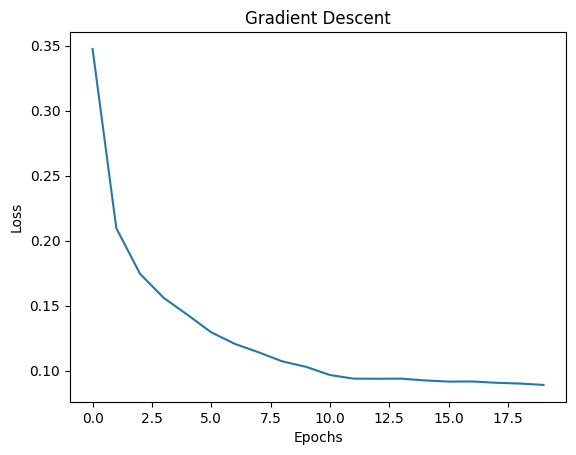

In [129]:
plt.plot(graph_loss)
plt.title("Gradient Descent")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Prediction

In [131]:
import torch
import torchvision
import torch.nn
import torch.nn.functional as F
import cv2


device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

cuda


In [132]:
testset=Data(test_im, test_txt, test=True)
test=DataLoader(testset,shuffle=True,num_workers=0,batch_size=1)

In [133]:
model=CTPN()
model.to(device)
model.eval()
cc=torch.load(os.path.join(checkpoints_dir,os.listdir(checkpoints_dir)[-1]), map_location=device)
model.load_state_dict(cc['model_state_dict'])

<All keys matched successfully>

In [134]:
def dfs(coors, vis, ind, proposals, prop):

    if vis[ind]==1:
        return

    vis[ind]=1

    coors[0]=min(coors[0], proposals[ind][0])
    coors[1]=min(coors[1], proposals[ind][1])
    coors[2]=max(coors[2], proposals[ind][2])
    coors[3]=max(coors[3], proposals[ind][3])

    for j in prop[ind]:
        dfs(coors, vis, j, proposals, prop)

    return

In [135]:
def text_connector(proposals):

    n=len(proposals)
    paired=[]

    for i in range(n):

        s=0
        dist=10000
        center=(proposals[i][0]+proposals[i][2])/2
        neighbour=[]
        paired.append([])

        for j in range(n):

            if i==j:
                continue

            temp=(proposals[j][0]+proposals[j][2])/2
            s=abs(center-temp)

            if s<dist:
                dist=s
                neighbour=[j]

            elif s==dist:
                neighbour.append(j)

        if dist<100:
            for j in neighbour:

                upper=max(proposals[i][1], proposals[j][1])
                lower=min(proposals[i][3], proposals[j][3])

                overlap=abs(upper-lower)

                if proposals[i][1]>proposals[j][3] or proposals[i][3]<proposals[j][1]:
                    overlap=0

                else:
                    overlap=min(-proposals[i][1]+proposals[j][3], proposals[i][3]-proposals[j][1])

                if overlap>0 and abs(proposals[i][1]-proposals[i][3])/overlap>0.7:
                    paired[i].append(j)

    prop=[]

    for i in range(n):
        prop.append([])
        for j in paired[i]:
            flag=0
            for h in paired[j]:

                if i==h:
                    flag=1
                    break
            if flag==1:
                prop[i].append(j)

    base=gen_anchor((height/16, width/16), 16)

    vis=np.zeros((n, 1))
    rect=[]
    for i in range(n):
        if vis[i]!=1:
            coors=[1000, 1000, 0, 0]
            dfs(coors, vis, i, proposals, prop)
            rect.append(coors)

    return rect

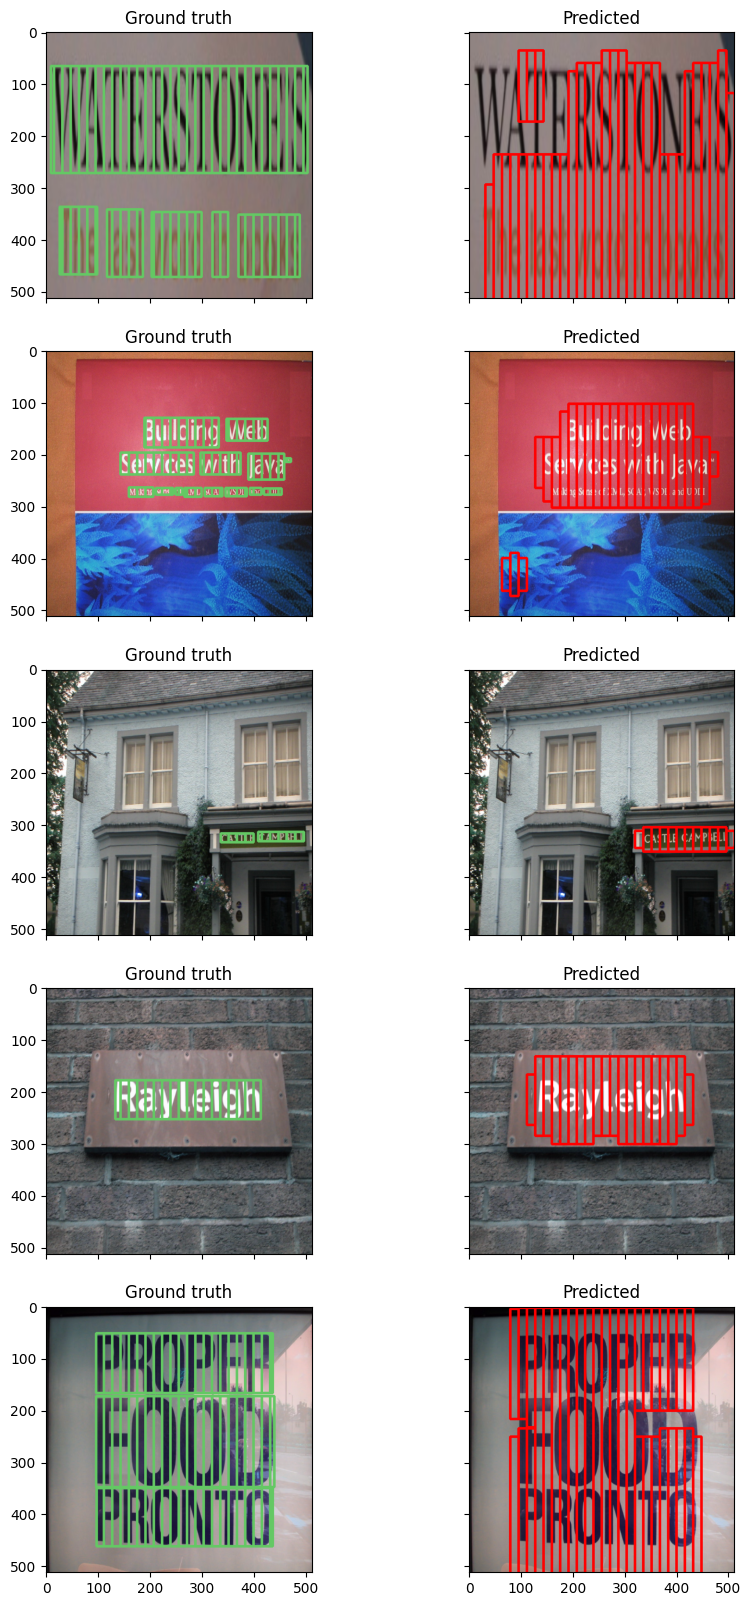

In [136]:
def pred(model):

    fig, ax=plt.subplots(5, 2, figsize=(10, 20), sharex=True, sharey=True)
    count=0
    for b, (d, img, regr, cls, refine) in enumerate(test):

        img=img.to(device)

        out_c, outr, _=model(img)
        out_c=out_c[0]
        outr=outr[0]
        out_c=F.softmax(out_c, dim=-1)
        base_anchors=gen_anchor((height/16, width/16), 16)

        ax[count, 0].imshow(d[0])
        ax[count, 0].set_title("Ground truth")

        d=img[0].long()
        d=np.transpose(d.cpu().numpy(), (1, 2, 0))
        d=cv2.resize(d,(height,width))

        proposals=[]

        for i in range(len(base_anchors)):

            if out_c[i][1]>0.7 and min(base_anchors[i])>0:
                cen, hght=outr[i]

                cen_a=(base_anchors[i][1]+base_anchors[i][3])/2
                hght_a=abs(base_anchors[i][1]-base_anchors[i][3])

                cen=cen*(hght_a)+cen_a

                hght=2.7**hght
                hght=hght*(hght_a)

                x1=int(base_anchors[i][0])
                y1=int(cen-(hght/2))
                x2=int(base_anchors[i][2])
                y2=int(cen+(hght/2))

                proposals.append([x1, y1, x2, y2])

        rect=text_connector(proposals)

        for i in range(len(rect)):
            x1, y1, x2, y2=rect[i]
            cv2.rectangle(d, (x1, y1), (x2, y2), (255, 0, 0), 3)

        ax[count, 1].imshow(d)
        ax[count, 1].set_title("Predicted")

        count+=1
        if count==5:
            break
    plt.show()

pred(model)